In [ ]:
!pip install tensorflow-gpu==2.0

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd gdrive/MyDrive/18786

/content/gdrive/MyDrive/18786


In [ ]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

print('[INFO]', tf.config.experimental.list_physical_devices('GPU')[0])

2.0.0
[INFO] PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
#Adversarial examples
adv_images = np.load('Copy of newadv_denoised10k.npz',allow_pickle=True)
ad_imgs = adv_images.files
ad_imgs = ad_imgs[0]


In [ ]:
images = adv_images[ad_imgs]

In [ ]:
adv_labels = np.load('Copy of adv_labels_fgsm.npz',allow_pickle=True)
labels = adv_labels[adv_labels.files[0]]

In [ ]:
labels = labels.reshape(-1,1)
labels.shape

(10000, 1)

In [ ]:
images_transf = (images*255).astype(int)

In [ ]:
sample_images = x_train[:32]
sample_labels = y_train[:32]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image)
  ax.set_title(label[0])

plt.show()


In [ ]:
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, label, batch_size=32, dim=(32, 32), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X            #same image goes in x and y
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      self.label = label
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    
    X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image

    y_label = []
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
      masked_image = self.__createMask(image_copy)
      
      X_batch[i,] = masked_image/255
      y_batch[i] = self.y[idx]/255
      
      y_label.append(self.label[idx])
    return X_batch, y_batch#, y_label

  def __createMask(self, img):
    mask = np.full((32,32,3), 255, np.uint8)
    for _ in range(19):
      x1, y1 = np.random.randint(1, 32), np.random.randint(1, 32)
      thickness = -1
      cv2.rectangle(mask,(x1,y1),(x1+2,y1+2),(1,1,1),thickness)
    masked_image = np.bitwise_and(img,mask)
    return masked_image


Try different mask sizes and shapes to see what gives the best reconstruction. Eg: cv2.rectangle, cv2.ellipse etc.

In [ ]:
fig = plt.figure(figsize=(3., 3.))
plt.imshow(x_train[1])
y_train[1]

In [ ]:
# traingen = createAugment(x_train, x_train)
# testgen = createAugment(x_test, x_test, shuffle=False)

#For natural images
traingen = createAugment(x_train, x_train, y_train)
#testgen = createAugment(x_test, x_test, y_test, shuffle=False)

#For adversarial images
testgen = createAugment(images_transf, images_transf, labels,shuffle = False)

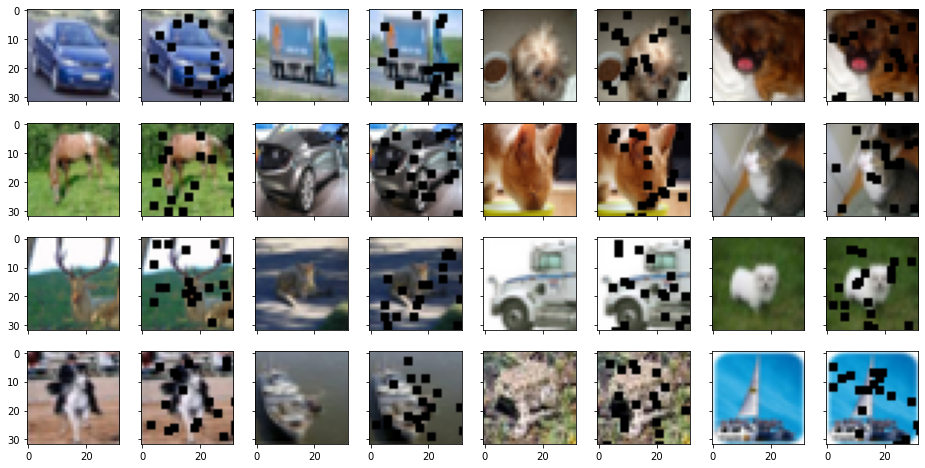

In [ ]:
sample_idx = 90 ## Change this to see different batches

sample_masks, sample_labels = traingen[sample_idx]
#sample_masks, sample_labels,categories = testgen[sample_idx]
sample_images = [None]*(len(sample_masks)+len(sample_labels))
sample_images[::2] = sample_labels
sample_images[1::2] = sample_masks

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))


In [ ]:
class inpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(32,32,3)):
    inputs = keras.layers.Input(input_size)

    conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs) 
    conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 
    
    conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    
    conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)
    
    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

    return keras.models.Model(inputs=[inputs], outputs=[outputs])  

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

In [ ]:
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[dice_coef])
keras.utils.plot_model(model, show_shapes=True, dpi=50, to_file='model_v1.png')

In [ ]:
class PredictionLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PredictionLogger, self).__init__()

    def on_epoch_end(self, logs, epoch):
        sample_idx = 54
        sample_images, sample_labels = testgen[sample_idx]  
        
        images = []
        labels = []
        predictions = []
        
        for i in range(32):
            inpainted_image = self.model.predict(np.expand_dims(sample_images[i], axis=0))

            images.append(sample_images[i])
            labels.append(sample_labels[i])
            predictions.append(inpainted_image.reshape(inpainted_image.shape[1:]))


In [ ]:
_ = model.fit(traingen, 
          validation_data=testgen, 
          epochs=20, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=True,
          callbacks=[PredictionLogger()])
model.save('/content/gdrive/MyDrive/18786/200_spotsepochs.h5')


In [ ]:
model.save('/content/gdrive/MyDrive/18786/200_spotsepochs.h5')

In [ ]:
dependencies = {
    'dice_coef': dice_coef
}

In [ ]:
model = keras.models.load_model("200_spotsepochs.h5",custom_objects=dependencies)

In [ ]:
#rows = 32
sample_idx = 312

label_list = []

inpainted_images = []

og_images = []

for index in range(sample_idx):
  print(index)

  # sample_images, sample_labels, categories = testgen[index]
  sample_images, sample_labels = testgen[index]
  #label_list+=categories
  for i in range(32):
    inpainted_image = model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
    inpainted_images.append(inpainted_image)
    
 


In [ ]:
rows = 32
sample_idx = 0
label_list = []
sample_images, sample_labels = testgen[sample_idx]
#sample_images, sample_labels = traingen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 2*rows))

inp_img = model.predict(sample_images[0].reshape((1,)+sample_images[0].shape))
axs[0][0].imshow(sample_labels[0])
axs[0][1].imshow(sample_images[0])
axs[0][2].imshow(inp_img.reshape(inp_img.shape[1:]))
#label_list+=categories
#inp_remaining = []
for i in range(32):
  inpainted_image = model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
  #inp_remaining.append(inpainted_image)
  #og_images.append(sample_labels[i])
  axs[i][0].imshow(sample_labels[i])
  axs[i][1].imshow(sample_images[i])
  axs[i][2].imshow(inpainted_image.reshape(inpainted_image.shape[1:]))
  


plt.show()

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(5, 5))
columns = 1
rows = 1
for i in range(1, rows+1):
    img = testgen[0][0][0].reshape(32,32,3)
    fig.add_subplot(rows,columns, i)
    plt.imshow(img)
    plt.savefig('clean2.png')
plt.show()


In [ ]:
inpainted_images_reshape = [i.reshape((32,32,3)) for i in inpainted_images]

In [ ]:
images = np.array(images)

In [ ]:
labels = np.array(labels)

In [ ]:
np.savez_compressed('test_denoisedadv_spots_inpainted',inpainted_images_reshape)